In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten
import matplotlib.pyplot as plt

# Define the folder names
TRAINING = ['MH_03_medium', 'V1_02_medium', 'V2_03_difficult', 'MH_02_easy', 'MH_04_difficult', 'V1_01_easy', 'V1_03_difficult', 'V2_02_medium']
VALIDATION = ['MH_05_difficult', 'V2_01_easy']
TEST = ['MH_01_easy']

# Function to load data and append camera results
def load_data(folders):
    data_dict = {}
    truth_dict = {}
    for name in folders:
        data_path = f'EuRoC/{name}/mav0/imu0/data.csv'
        truth_path = f'EuRoC/{name}/mav0/state_groundtruth_estimate0/data.csv'
        camera_path = f'camera/{name}-results.csv'
        
        # Load the datasets
        data_df = pd.read_csv(data_path)
        truth_df = pd.read_csv(truth_path)
        camera_df = pd.read_csv(camera_path)
        
        # Interpolate camera data to match the length of data_df
        new_index = np.linspace(0, len(camera_df) - 1, len(data_df))
        camera_interpolated = camera_df.reindex(new_index).interpolate(method='linear')
        
        # Reset index to align properly
        camera_interpolated.reset_index(drop=True, inplace=True)
        data_df.reset_index(drop=True, inplace=True)
        
        # Combine the dataframes
        combined_df = pd.concat([data_df, camera_interpolated], axis=1)
        
        # Store in dictionaries
        data_dict[name] = combined_df
        truth_dict[name] = truth_df
    
    return data_dict, truth_dict

# Load datasets
train_data_dict, train_truth_dict = load_data(TRAINING)
val_data_dict, val_truth_dict = load_data(VALIDATION)
test_data_dict, test_truth_dict = load_data(TEST)

# Combine datasets
train_data = pd.concat(train_data_dict.values())
train_truth = pd.concat(train_truth_dict.values())
val_data = pd.concat(val_data_dict.values())
val_truth = pd.concat(val_truth_dict.values())
test_data = pd.concat(test_data_dict.values())
test_truth = pd.concat(test_truth_dict.values())

# Clean up column names to remove leading and trailing spaces
train_truth.columns = train_truth.columns.str.strip()
val_truth.columns = val_truth.columns.str.strip()
test_truth.columns = test_truth.columns.str.strip()

print('Loading complete')


Loading complete


In [7]:
# Define features and targets
features = ['w_RS_S_x [rad s^-1]', 'w_RS_S_y [rad s^-1]', 'w_RS_S_z [rad s^-1]', 
            'a_RS_S_x [m s^-2]', 'a_RS_S_y [m s^-2]', 'a_RS_S_z [m s^-2]', 'x', 'y', 'z']
targets = ['p_RS_R_x [m]', 'p_RS_R_y [m]', 'p_RS_R_z [m]']

# Scale the features
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_data[features])
val_X_scaled = scaler.transform(val_data[features])
test_X_scaled = scaler.transform(test_data[features])

# Align lengths by trimming the excess IMU data entries
aligned_length = min(len(train_X_scaled), len(train_truth[targets].values))
train_X_scaled = train_X_scaled[:aligned_length]
train_truth_aligned = train_truth[targets].values[:aligned_length]

aligned_length_val = min(len(val_X_scaled), len(val_truth[targets].values))
val_X_scaled = val_X_scaled[:aligned_length_val]
val_truth_aligned = val_truth[targets].values[:aligned_length_val]

aligned_length_test = min(len(test_X_scaled), len(test_truth[targets].values))
test_X_scaled = test_X_scaled[:aligned_length_test]
test_truth_aligned = test_truth[targets].values[:aligned_length_test]

# Convert the data into sequences
def create_sequences(data, truth, sequence_length=50):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        labels.append(truth[i+sequence_length])
    return np.array(sequences), np.array(labels)

sequence_length = 50
X_train, y_train = create_sequences(train_X_scaled, train_truth_aligned, sequence_length)
X_val, y_val = create_sequences(val_X_scaled, val_truth_aligned, sequence_length)
X_test, y_test = create_sequences(test_X_scaled, test_truth_aligned, sequence_length)

print('input sequences complete')

input sequences complete


In [8]:
# Define the model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, len(features))),
    MaxPooling1D(pool_size=2),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(100, activation='relu'),
    Dense(len(targets))
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

# Export the model
model.save('trajectory_model.h5')

print('model training complete')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 48, 64)            1792      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 24, 64)           0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 24, 50)            23000     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 100)               5100      
                                                                 
 dense_3 (Dense)             (None, 3)                 303       
                                                      

1136/1136 [==============================] - 10s 8ms/step


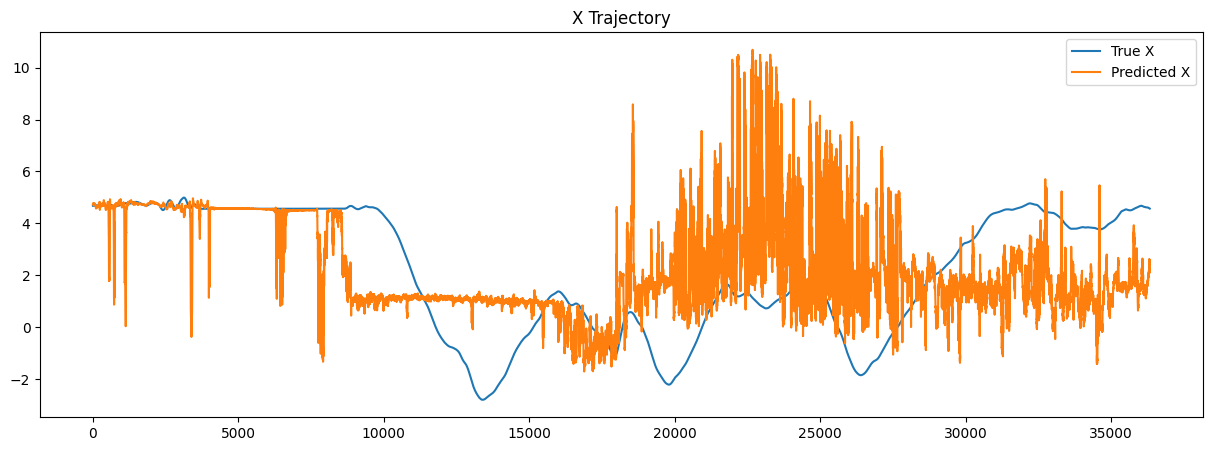

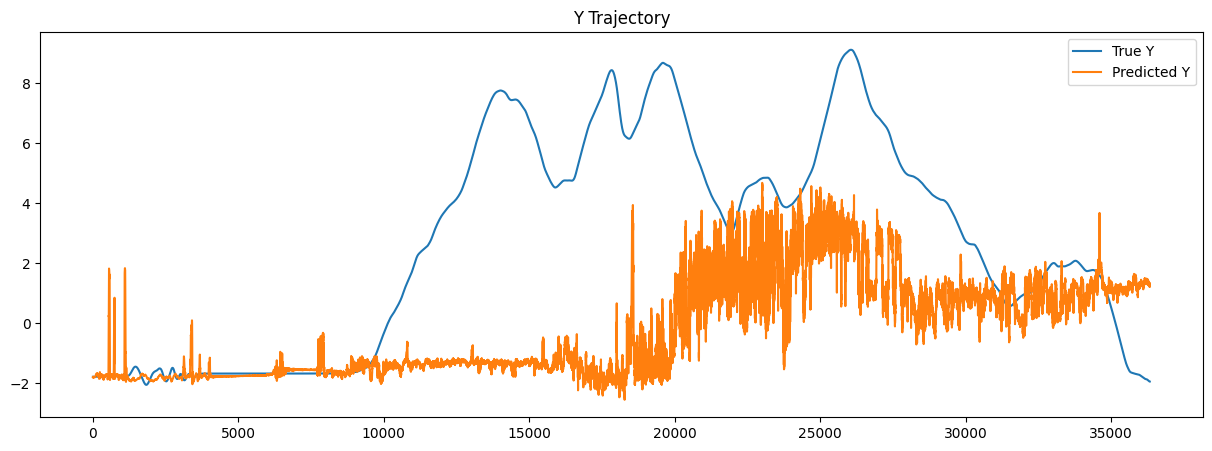

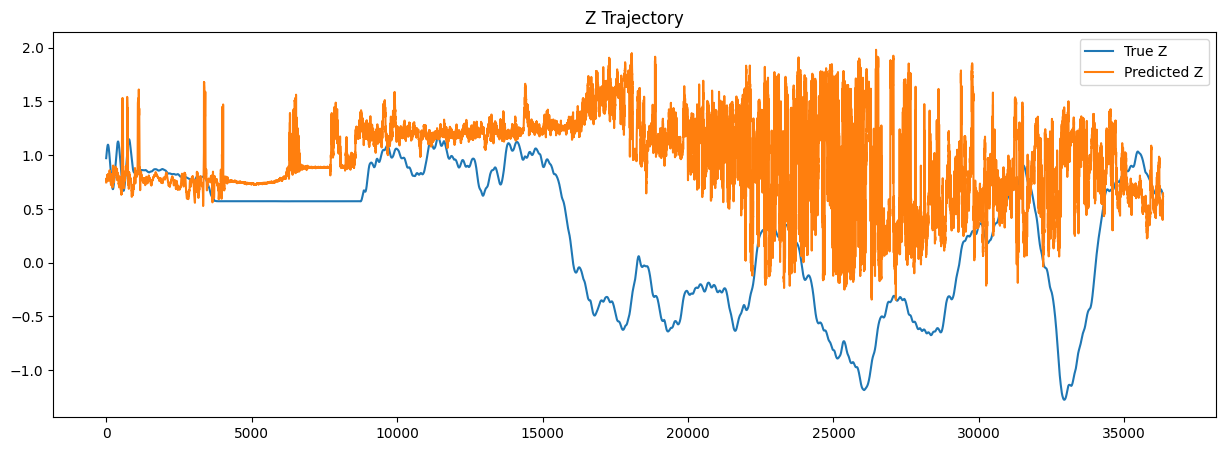

In [4]:
# Load the model and test it
loaded_model = load_model('trajectory_model.h5')

# Predict using the test data
y_pred = loaded_model.predict(X_test)

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 0], label='True X')
plt.plot(y_pred[:, 0], label='Predicted X')
plt.legend()
plt.title('X Trajectory')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 1], label='True Y')
plt.plot(y_pred[:, 1], label='Predicted Y')
plt.legend()
plt.title('Y Trajectory')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 2], label='True Z')
plt.plot(y_pred[:, 2], label='Predicted Z')
plt.legend()
plt.title('Z Trajectory')
plt.show()

In [5]:
# Load the model and test it
loaded_model = load_model('trajectory_model.h5')

# Predict using the test data
y_pred = loaded_model.predict(X_test)

# Calculate the RMSE
rmse_before_filter = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE before filtering: {rmse_before_filter}')

# Apply a moving average filter to the predicted data
def moving_average(data, window_size=250):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply moving average filter to each predicted dimension separately
y_pred_filtered = np.array([moving_average(y_pred[:, i]) for i in range(y_pred.shape[1])]).T

# Align the test data to match the length of the filtered predictions
y_test_aligned = y_test[len(y_test) - len(y_pred_filtered):]

# Calculate the RMSE again after filtering
rmse_after_filter = np.sqrt(mean_squared_error(y_test_aligned, y_pred_filtered))
print(f'RMSE after filtering: {rmse_after_filter}')

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 0], label='True X')
plt.plot(y_pred[:, 0], label='Predicted X')
plt.plot(y_pred_filtered[:, 0], label='Filtered Predicted X')
plt.legend()
plt.title('X Trajectory')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 1], label='True Y')
plt.plot(y_pred[:, 1], label='Predicted Y')
plt.plot(y_pred_filtered[:, 1], label='Filtered Predicted Y')
plt.legend()
plt.title('Y Trajectory')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 2], label='True Z')
plt.plot(y_pred[:, 2], label='Predicted Z')
plt.plot(y_pred_filtered[:, 2], label='Filtered Predicted Z')
plt.legend()
plt.title('Z Trajectory')
plt.show()

1136/1136 [==============================] - 10s 8ms/step


NameError: name 'mean_squared_error' is not defined

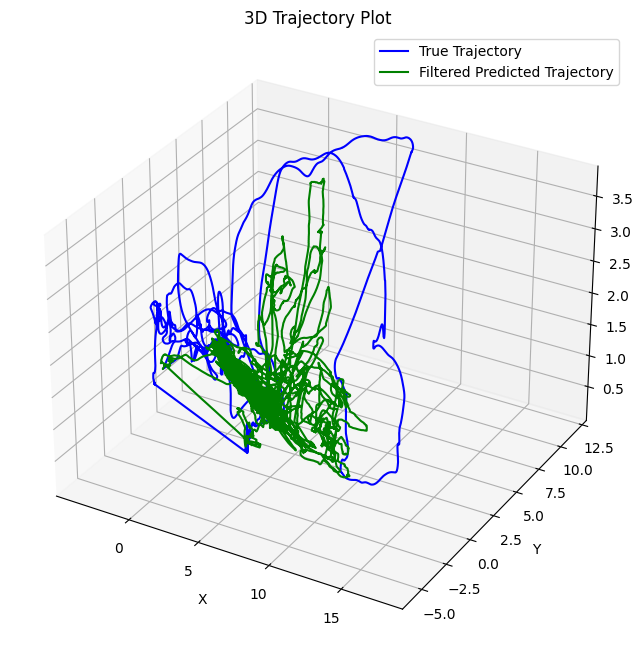

In [42]:
from mpl_toolkits.mplot3d import Axes3D
# 3D Plot of the trajectories
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot True Trajectory
ax.plot(y_test[:, 0], y_test[:, 1], y_test[:, 2], label='True Trajectory', color='blue')

# Plot Predicted Trajectory
#ax.plot(y_pred[:, 0], y_pred[:, 1], y_pred[:, 2], label='Predicted Trajectory', color='red')

# Plot Filtered Predicted Trajectory
ax.plot(y_pred_filtered[:, 0], y_pred_filtered[:, 1], y_pred_filtered[:, 2], label='Filtered Predicted Trajectory', color='green')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.title('3D Trajectory Plot')
plt.show()